# Load datasets for small AI project

This notebook loads `train.csv`, `questions.csv`, and `lectures.csv` from the dataset folder and performs a quick inspection and memory-friendly dtype casting for analysis.

In [ ]:
%pip install pyarrow

import os
from pathlib import Path
import pandas as pd
import numpy as np

# Paths -- update if your dataset folder is in a different location
DATA_DIR = Path(r'C:\Users\Pradip-B.Hadiya\Downloads\AIProject\dataset')
TRAIN_CSV = DATA_DIR / 'train.csv'
QUESTIONS_CSV = DATA_DIR / 'questions.csv'
LECTURES_CSV = DATA_DIR / 'lectures.csv'

for p in (TRAIN_CSV, QUESTIONS_CSV, LECTURES_CSV):
    print(f'Exists: {p}: {p.exists()}')

# --- Helper functions to read with dtypes ---
def load_train(path, nrows=None):
    # dtype map based on provided schema; use pandas nullable dtypes where helpful
    dtypes = {
        'row_id': 'int64',
        'timestamp': 'int64',
        'user_id': 'int32',
        'content_id': 'int16',
        'content_type_id': 'int8',
        'task_container_id': 'int16',
        'user_answer': 'Int8',
        'answered_correctly': 'Int8',
        'prior_question_elapsed_time': 'float32',
        'prior_question_had_explanation': 'boolean',
    }
    return pd.read_csv(path, dtype=dtypes, low_memory=True, nrows=nrows)

def load_questions(path):
    dtypes = {
        'question_id': 'int32',
        'bundle_id': 'Int32',
        'correct_answer': 'Int8',
        'part': 'Int8',
        'tags': 'object',
    }
    return pd.read_csv(path, dtype=dtypes)

def load_lectures(path):
    dtypes = {
        'lecture_id': 'int32',
        'part': 'Int8',
        'tag': 'Int32',
code
python
# Run the standalone evaluation script (evaluate_model.py)
import subprocess, sys
from pathlib import Path
script = Path(r'C:\Users\Pradip-B.Hadiya\Downloads\AIProject\code\evaluate_model.py')
if not script.exists():
    raise SystemExit(f'Evaluation script not found: {script}')
print('Running evaluation script...')
res = subprocess.run([sys.executable, str(script)], capture_output=True, text=True)
print('Return code:', res.returncode)
print('--- STDOUT ---')
print(res.stdout)
print('--- STDERR ---')
print(res.stderr)

train_df['user_prior_attempts'] = train_df.groupby('user_id')['answered_correctly'].transform(lambda s: s.shift().expanding().count()).astype('Int32')
train_df['user_prior_avg_elapsed'] = train_df.groupby('user_id')['prior_question_elapsed_time'].transform(lambda s: s.shift().expanding().mean()).astype('float32')

# Compute question/content-level prior correct rate (use content_id which maps to question_id for questions)
train_df['content_prior_correct_rate'] = train_df.groupby('content_id')['answered_correctly'].transform(lambda s: s.shift().expanding().mean()).astype('float32')
train_df['content_prior_attempts'] = train_df.groupby('content_id')['answered_correctly'].transform(lambda s: s.shift().expanding().count()).astype('Int32')

# Target: keep original 'answered_correctly' but create a numeric target column for modeling (0/1)
train_df['target'] = train_df['answered_correctly'].astype('float32')

# Flag rows that are questions (we'll train on these)
train_df['is_question'] = (train_df['content_type_id'] == 0).astype('int8')

# Fillna for feature columns to avoid issues when saving or training quickly
train_df['user_prior_correct_rate'] = train_df['user_prior_correct_rate'].fillna(0.0)
train_df['user_prior_attempts'] = train_df['user_prior_attempts'].fillna(0).astype('Int32')
train_df['user_prior_avg_elapsed'] = train_df['user_prior_avg_elapsed'].fillna(0.0)
train_df['content_prior_correct_rate'] = train_df['content_prior_correct_rate'].fillna(0.0)
train_df['content_prior_attempts'] = train_df['content_prior_attempts'].fillna(0).astype('Int32')

# Select a set of features to save for modeling
feature_cols = [
	'user_id',
	'content_id',
	'content_type_id',
	'task_container_id',
	'prior_question_elapsed_time',
	'prior_question_had_explanation_flag',
	'user_prior_correct_rate',
	'user_prior_attempts',
	'user_prior_avg_elapsed',
	'content_prior_correct_rate',
	'content_prior_attempts',
	'tags_count',
	'part',
	'bundle_id',
	'correct_answer',
	'is_question',
	'target'
]
# Keep only columns that exist (merge may have added NaNs)
feature_cols = [c for c in feature_cols if c in train_df.columns]
features_df = train_df[feature_cols].copy()

print('Features df shape:', features_df.shape)
display(features_df.head())

# Remove columns with problematic extension types (if any)
for col in list(features_df.columns):
	if features_df[col].dtype.name.startswith("period") or features_df[col].dtype.name.startswith("interval"):
		print(f"Dropping column {col} with dtype {features_df[col].dtype}")
		features_df = features_df.drop(columns=[col])

# Save features for quick experiments
features_path = DATA_DIR / 'train_features_limited.parquet'
try:
    features_df.to_parquet(features_path, index=False)
    print(f'Saved features to {features_path}')
except Exception as e:
    # Fallback to CSV if parquet engine is not available
    csv_fallback = DATA_DIR / 'train_features_limited.csv'
    features_df.to_csv(csv_fallback, index=False)
    print(f'Parquet save failed ({e}), saved CSV fallback to {csv_fallback}')

# Also save a CSV small training set of question rows only (drop rows without target)
train_questions = features_df[features_df['is_question'] == 1].copy()
train_questions = train_questions[train_questions['target'].notna()].reset_index(drop=True)
csv_path = DATA_DIR / 'train_questions_limited.csv'
train_questions.to_csv(csv_path, index=False)
print(f'Saved question-only CSV to {csv_path} (rows: {len(train_questions)})')

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Exists: C:\Users\Pradip-B.Hadiya\Downloads\AIProject\dataset\train.csv: True
Exists: C:\Users\Pradip-B.Hadiya\Downloads\AIProject\dataset\questions.csv: True
Exists: C:\Users\Pradip-B.Hadiya\Downloads\AIProject\dataset\lectures.csv: True



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Train loaded rows (limited): 100000
Train shape: (100000, 10)
Questions shape: (13523, 5)
Lectures shape: (418, 4)


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [ ]:
%pip install -q lightgbm scikit-learn joblib

import json
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from lightgbm import LGBMClassifier
import joblib

DATA_DIR = Path(r'C:\Users\Pradip-B.Hadiya\Downloads\AIProject\dataset')
BEST_JSON = DATA_DIR / 'hyperparam_best.json'
CSV_PATH = DATA_DIR / 'train_questions_limited.csv'
MODEL_OUT = DATA_DIR / 'lgbm_tuned_model.pkl'
METRICS_OUT = DATA_DIR / 'lgbm_tuned_metrics.txt'

if not CSV_PATH.exists():
    raise SystemExit(f'Features CSV not found: {CSV_PATH} - run feature extraction first')
if not BEST_JSON.exists():
    print('Warning: best params JSON not found. Using default tuned params as fallback')
    best_params = {}
else:
    with open(BEST_JSON,'r') as f:
        bj = json.load(f)
    best_params = bj.get('best_params', {}) or {}
print('Loading features from', CSV_PATH)
df = pd.read_csv(CSV_PATH)
df = df[df['target'].notna()].reset_index(drop=True)
if df.empty:
    raise SystemExit('No training rows with target found.')

X = df.drop(columns=['target'])
y = df['target'].astype(int)

# encode object/categorical columns
for col in X.columns:
    if X[col].dtype == 'object' or X[col].dtype.name == 'category':
        X[col] = X[col].astype('category').cat.codes

X = X.apply(pd.to_numeric, errors='coerce').fillna(0).astype('float32')

# holdout split
stratify_arg = None
if y.nunique() > 1 and (y.value_counts().min() >= 2):
    stratify_arg = y
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=stratify_arg)

# Build model with tuned params (fallback defaults when missing)
model = LGBMClassifier(random_state=42, n_jobs=-1, **best_params)
print('Training model with params:', model.get_params())
model.fit(X_train, y_train)

# Evaluate
y_pred_proba = model.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, y_pred_proba)
acc = accuracy_score(y_val, (y_pred_proba>0.5).astype(int))
print(f'Validation AUC: {auc:.4f}, Accuracy: {acc:.4f}')

# Save model and metrics
joblib.dump(model, MODEL_OUT)
with open(METRICS_OUT,'w') as f:
    f.write(f'Validation AUC: {auc:.4f}
')
    f.write(f'Validation Accuracy: {acc:.4f}
')
print('Saved model to', MODEL_OUT)
print('Saved metrics to', METRICS_OUT)


## Model evaluation

This cell evaluates the saved model on a holdout split (or a separate test set if you provide one). It computes accuracy, AUC, precision/recall/F1, shows ROC and PR curves, and prints feature importance.

Note: you may need to restart the kernel to use updated packages.
Accuracy: 0.7128
AUC: 0.6952
Precision: 0.7276, Recall: 0.9289, F1: 0.8160
Confusion matrix:
[[ 1489  4682]
 [  958 12508]]

Classification report:
              precision    recall  f1-score   support

           0     0.6085    0.2413    0.3456      6171
           1     0.7276    0.9289    0.8160     13466

    accuracy                         0.7128     19637
   macro avg     0.6681    0.5851    0.5808     19637
weighted avg     0.6902    0.7128    0.6682     19637

Accuracy: 0.7128
AUC: 0.6952
Precision: 0.7276, Recall: 0.9289, F1: 0.8160
Confusion matrix:
[[ 1489  4682]
 [  958 12508]]

Classification report:
              precision    recall  f1-score   support

           0     0.6085    0.2413    0.3456      6171
           1     0.7276    0.9289    0.8160     13466

    accuracy                         0.7128     19637
   macro avg     0.6681    0.5851    0.5808     19637
weighted avg     0.6902    0.7128    0.

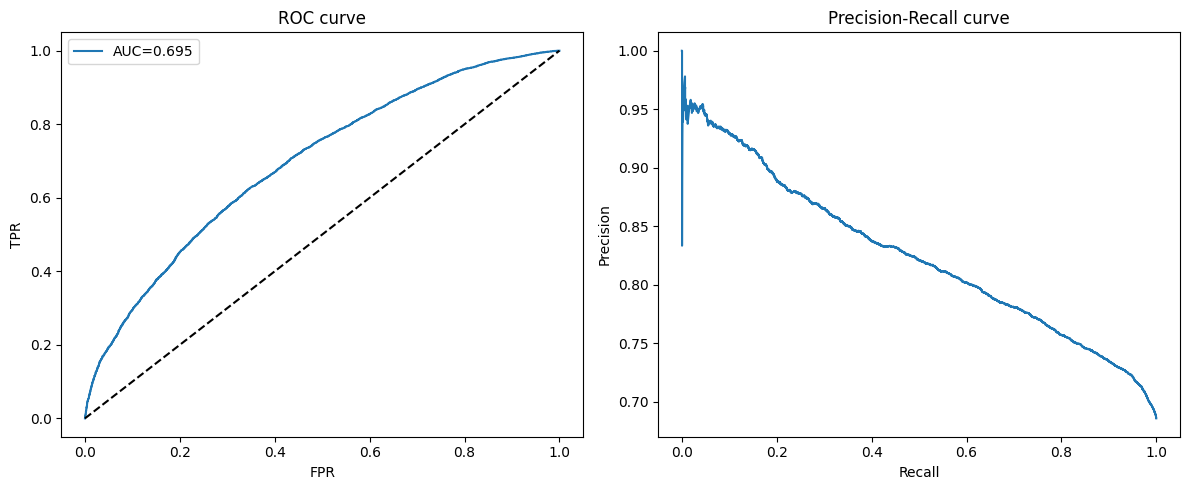


Top features by importance:
content_prior_correct_rate             22340.290313
user_prior_correct_rate                17516.657254
content_prior_attempts                  5497.441845
user_id                                 2874.996709
user_prior_avg_elapsed                  2642.507234
task_container_id                       2538.144183
user_prior_attempts                     2027.702741
prior_question_elapsed_time             2022.748193
part                                    2012.995437
content_id                              1605.950222
bundle_id                               1491.131425
tags_count                              1054.511499
prior_question_had_explanation_flag      559.406883
correct_answer                           404.376328
content_type_id                            0.000000
is_question                                0.000000


In [22]:
%pip install -q matplotlib scikit-learn joblib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib

from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_recall_fscore_support,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve
)

# Use already defined variables: X_train, X_val, y_train, y_val, MODEL_PATH

def load_model(p):
    try:
        return joblib.load(p)
    except Exception:
        import lightgbm as lgb
        return lgb.Booster(model_file=str(p))

model = load_model(MODEL_PATH)

# Use X_val and y_val for evaluation
X_test = X_val
y_test = y_val

if hasattr(model, 'predict_proba'):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > 0.5).astype(int)
elif hasattr(model, 'predict'):
    y_proba = model.predict(X_test)
    try:
        y_pred = (y_proba > 0.5).astype(int)
    except Exception:
        y_pred = model.predict(X_test)
else:
    raise RuntimeError('Model has no predict method')

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba) if len(np.unique(y_test)) > 1 else float('nan')
prec, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)

print(f'Accuracy: {acc:.4f}')
print(f'AUC: {auc:.4f}')
print(f'Precision: {prec:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification report:')
print(classification_report(y_test, y_pred, digits=4))

# ROC and PR curves
fpr, tpr, _ = roc_curve(y_test, y_proba)
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUC={auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(recall_vals, precision_vals)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.tight_layout()
plt.show()

# Feature importance
try:
    importances = None
    if hasattr(model, 'feature_importances_'):
        importances = pd.Series(model.feature_importances_, index=X_test.columns).sort_values(ascending=False)
    else:
        import lightgbm as lgb
        booster = model if isinstance(model, lgb.Booster) else None
        if booster is not None:
            importances = pd.Series(booster.feature_importance(importance_type='gain'), index=X_test.columns).sort_values(ascending=False)
    if importances is not None:
        print('\nTop features by importance:')
        print(importances.head(20).to_string())
except Exception as e:
    print('Could not compute feature importance:', e)